# Default Poly

This notebook was created to find the right parameters to work with *some* polynomials. All resulting polynomials will then be combined for training data in a deep learning model.

In [1]:
%%javascript 
// To get notebook's full path
var kernel = Jupyter.notebook.kernel; 
var command = ["notebookPath = ",
               "'", window.document.body.dataset.notebookPath, "'" ].join('')
//alert(command)
kernel.execute(command)
var command = ["notebookName = ",
               "'", window.document.body.dataset.notebookName, "'" ].join('')
//alert(command)
kernel.execute(command)

<IPython.core.display.Javascript object>

In [53]:
%matplotlib inline
import os, sys

dir_path = os.path.dirname(os.path.abspath(notebookName))

# Path to Computer root directory
ROOT_DIR = os.path.realpath(os.path.join(dir_path, '..', '..'))

sys.path.append(ROOT_DIR)
from libraries.helpers import configuration, prepare_initial_transformation, \
                              preprocess_line_finding, resize_image_by_pil, load_from
from libraries.find_lines_sliding_windows import FindLinesSlidingWindows
from libraries.line_helpers import annotate_with_lines

import pdb
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from ipywidgets import widgets, Checkbox, FloatSlider, IntSlider, IntRangeSlider, FloatRangeSlider, RadioButtons
from IPython.core.display import clear_output, display
import math

config = configuration()

TARGET_WIDTH = config['target_width']
TARGET_HEIGHT = config['target_height']
TARGET_CROP = config['target_crop']
STEER_MIN = config['steer_min']
STEER_MAX = config['steer_max']
CHANNELS = config['channels']
NORMALIZE = config['normalize']
TARGET_SCALE = config['target_scale']
# TARGET_SCALE = 1.0

# Set this to images directory
img_dir = "/home/jay/Self-Driving-RC-Data/recorded-2017-06-11-test"

lists_to_exclude = [os.path.basename(i) for i in glob.glob(os.path.join(img_dir, "poly*.txt"))]
images_to_exclude = []
for list_path in lists_to_exclude:
    # Set this to a .txt file that contains filenames.
    images_to_exclude += list(
        map(lambda x: os.path.join(img_dir, 'recorded', x), load_from(os.path.join(img_dir, list_path))))
img_paths = glob.glob("/home/jay/Self-Driving-RC-Data/recorded-2017-06-11-test/recorded/*.jpg")

img_paths = sorted([i for i in img_paths if i not in images_to_exclude])

mtx, dist, M, Minv = prepare_initial_transformation(
    os.path.join(ROOT_DIR, 'calibrations', 'cal-elp.p'), TARGET_HEIGHT, TARGET_WIDTH, scale=TARGET_SCALE)
print("Number of images:", len(img_paths))

Number of images: 31


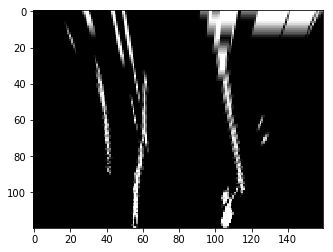

In [54]:
def find_color_hsv(change=None):
    inrange_min1 = inrange_min1_i.value
    inrange_min2 = inrange_min2_i.value
    inrange_min3 = inrange_min3_i.value
    inrange_max1 = inrange_max1_i.value
    inrange_max2 = inrange_max2_i.value
    inrange_max3 = inrange_max3_i.value
    
    img_path = '/home/jay/Self-Driving-RC-Data/recorded-2017-06-11-test/recorded/2017-06-12_05-10-44.837855.jpg'
    img_raw = cv2.imread(img_path)
    warped = preprocess_line_finding(img_raw, M, scale=TARGET_SCALE, inrange=((inrange_min1, inrange_min2, inrange_min3),
                                                  (inrange_max1, inrange_max2, inrange_max3)))
    plt.imshow(warped, cmap='gray')  

    clear_output(True)

inrange_min1_i = IntSlider(description='inrange min 1', min=0, max=255, step=1, value=106)
inrange_min2_i = IntSlider(description='inrange min 2', min=0, max=255, step=1, value=11)
inrange_min3_i = IntSlider(description='inrange min 3', min=0, max=255, step=1, value=11)
inrange_max1_i = IntSlider(description='inrange max 1', min=1, max=255, step=1, value=255)
inrange_max2_i = IntSlider(description='inrange max 2', min=1, max=255, step=1, value=109)
inrange_max3_i = IntSlider(description='inrange max 3', min=1, max=255, step=1, value=209)

inrange_min1_i.observe(find_color_hsv, 'value')
inrange_min2_i.observe(find_color_hsv, 'value')
inrange_min3_i.observe(find_color_hsv, 'value')
inrange_max1_i.observe(find_color_hsv, 'value')
inrange_max2_i.observe(find_color_hsv, 'value')
inrange_max3_i.observe(find_color_hsv, 'value')

display(inrange_min1_i, inrange_min2_i, inrange_min3_i,
        inrange_max1_i, inrange_max2_i, inrange_max3_i)
find_color_hsv()

/home/jay/Self-Driving-RC-Data/recorded-2017-06-11-test/recorded/2017-06-12_05-10-57.348232.jpg
line 1 error: 0.6417227354510687 (v)
line 1 coefs: [ -3.78234386e-03   2.24901838e-01   5.99254514e+01]
line 2 error: 1.0121232963951377 (v)
line 2 coefs: [  1.47366990e-03  -5.53508397e-01   1.32733876e+02]


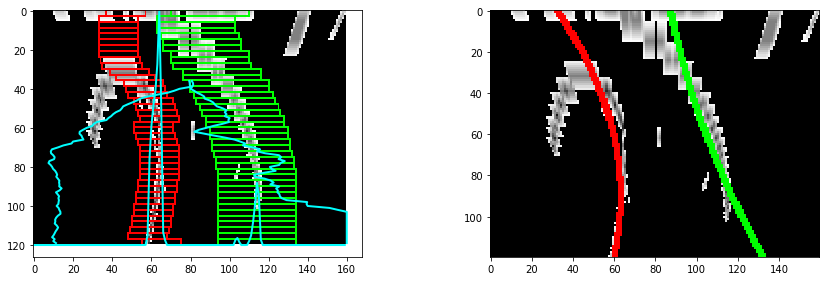

In [83]:
fig = plt.figure(figsize=(15, 10))
local_paths = img_paths[10:11]

i = 1
total = len(local_paths) * 2
cols = 2
for img_path in local_paths:
    print(img_path)
    a = fig.add_subplot((total/cols)+1, cols, i)
    img_raw = cv2.imread(img_path)
    img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

    preprocessed = preprocess_line_finding(img_raw, M, scale=TARGET_SCALE)
    finder = FindLinesSlidingWindows(nwindows=40, window_minpix=2, left_search_margin=20, right_search_margin=40,
                                     v_hist_crop_top=0.6, h_hist_crop_top=0.3, error_threshold=40, window_patience=6,
                                     window_empty_px=5, lr_start_slack=0.1, error_top_percentile=80,
                                     center_importance=4, vert_x_adjust=(2, 0), scale=TARGET_SCALE,
                                     debug_axes_for_histogram=a,
                                     debug=True, debug_dir='v', debug_show_lines=False, debug_error_detail=False)

    fits = finder.process(preprocessed)

    final_img = annotate_with_lines(preprocessed, fits, scale=TARGET_SCALE)
    
    i += 1
    a = fig.add_subplot((total/cols)+1, cols, i)
    plt.imshow(final_img, cmap='gray')


/home/jay/Self-Driving-RC-Data/recorded-2017-06-11-test/recorded/2017-06-12_05-10-57.348232.jpg
line 1 error: 4.81301993468162 (v)
line 1 coefs: [ -4.14034932e-03   6.49669555e-01   1.08221687e+02]
line 2 error: 0.2459808944255176 (v)
line 2 coefs: [ -3.35116684e-03   4.15641836e-01   2.15172547e+02]


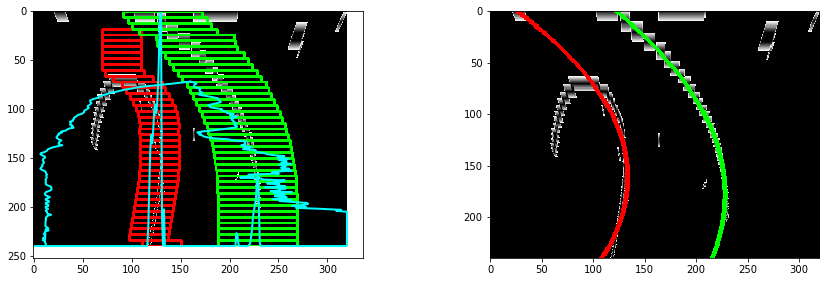

In [50]:
fig = plt.figure(figsize=(15, 10))
local_paths = img_paths[10:11]

i = 1
total = len(local_paths) * 2
cols = 2
for img_path in local_paths:
    print(img_path)
    a = fig.add_subplot((total/cols)+1, cols, i)
    img_raw = cv2.imread(img_path)
    img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

    preprocessed = preprocess_line_finding(img_raw, M, scale=TARGET_SCALE)
    finder = FindLinesSlidingWindows(nwindows=40, window_minpix=2, left_search_margin=20, right_search_margin=40,
                                     v_hist_crop_top=0.6, h_hist_crop_top=0.3, error_threshold=40, window_patience=6,
                                     window_empty_px=5, lr_start_slack=0.1, error_top_percentile=80,
                                     center_importance=4, vert_x_adjust=(2, 0), scale=TARGET_SCALE,
                                     debug_axes_for_histogram=a,
                                     debug=True, debug_dir='v', debug_show_lines=False, debug_error_detail=False)

    fits = finder.process(preprocessed)

    final_img = annotate_with_lines(preprocessed, fits, scale=TARGET_SCALE)
    
    i += 1
    a = fig.add_subplot((total/cols)+1, cols, i)
    plt.imshow(final_img, cmap='gray')


In [5]:
# SymPy implementation, not working yet.
from sympy.abc import x, y
from sympy import solve

a = -4.49307936e-04
b = 1.28758252e-01
c = 9.55947253e+01

d = -9.24515291e-04
e = 2.67924822e-01
f = 2.94245388e+02

# x = a*y**2+b*y+c
# y = d*x**2+e*x+f
print(solve([y-f, a*y**2+b*y+c]))

print(solve([(y-f-e)/d, a*y**2+b*y+c]))

print(solve([(x-c-b)/a, d*x**2+e*x+f]))
print(solve([a*x**2+b*x+c, d*x**2+e*x+f]))

[{y: 294.245388000000, y**2: 297081.881763027}]
[{y: 294.513312822000, y**2: 297158.661025052}]
[{x: 95.7234835520002, x**2: 346010.594314648}]
[{x: -32664.1734552358, x**2: -9147817.83827865}]


In [6]:
# Naive implementation
# a got 0, 2 and b got 2, 0.
a = np.array([2, 3])
b = np.array([1, 3, 0])
overlapping = False
for i1, i2 in enumerate(a):
    i2 = int(i2)
    for j1, j2 in enumerate(b):
        j2 = int(j2)
        if i1 == j2 and i2 == j1:
            print(i1, i2)
            overlapping = True
    if overlapping:
        break
print(overlapping)

0 2
True


2017-06-12_05-10-57.348232.jpg
2017-06-12_05-10-57.812471.jpg
2017-06-12_05-10-59.657861.jpg
2017-06-12_05-11-01.396103.jpg
2017-06-12_05-11-01.829160.jpg
2017-06-12_05-11-02.298654.jpg
2017-06-12_05-11-07.784162.jpg
2017-06-12_05-11-08.248350.jpg
2017-06-12_05-11-11.144953.jpg
2017-06-12_05-11-12.384675.jpg


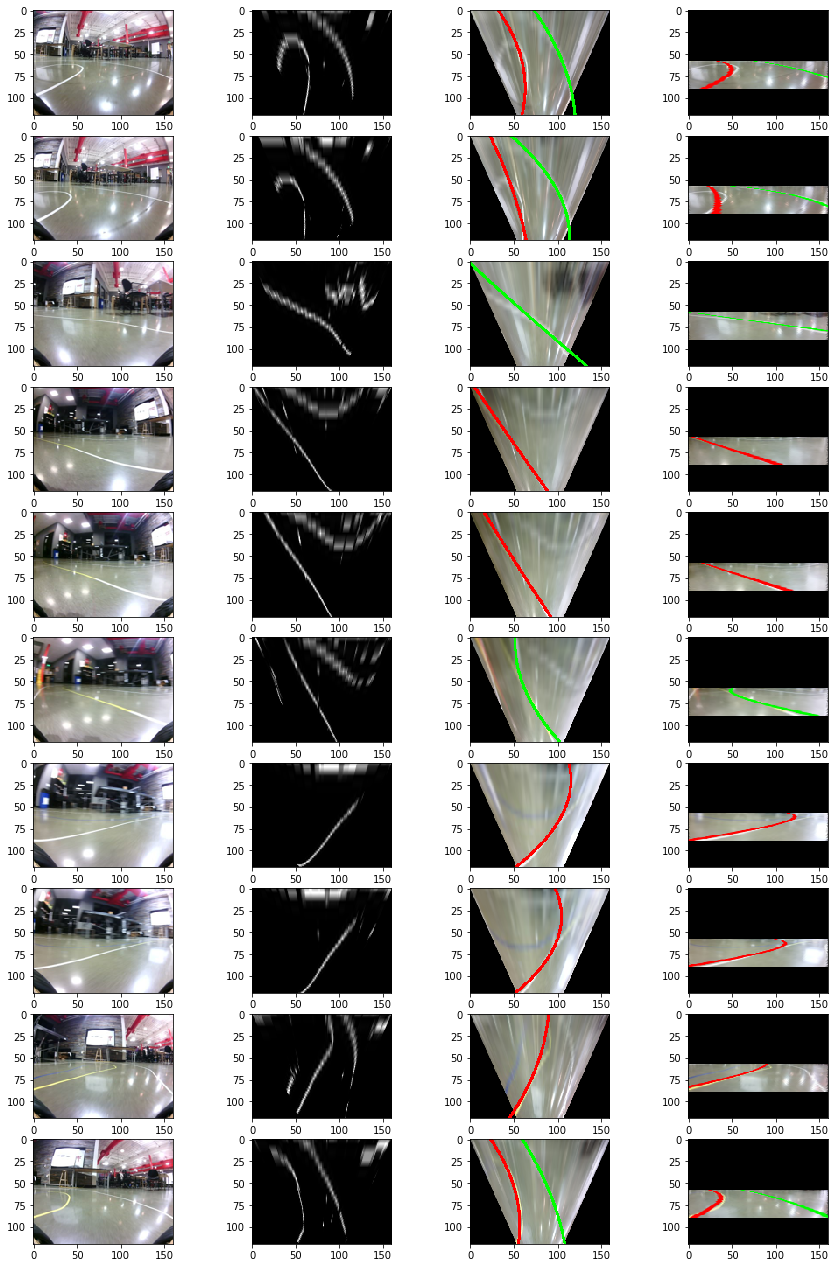

In [65]:
local_paths = img_paths[10:20]

i = 1
total = len(local_paths)*4
cols = 4
fig = plt.figure(figsize=(15, (total/cols)*2.5))
for img_path in local_paths:
    print(os.path.basename(img_path))
    img_raw = cv2.imread(img_path)
    img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
    img = resize_image_by_pil(img, TARGET_SCALE)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))

    # Display the original, undistorted, and warped image
    a = fig.add_subplot((total/cols)+1, cols, i)
    plt.imshow(img)
    i+=1
    
    preprocessed = preprocess_line_finding(img_raw, M, scale=TARGET_SCALE)
    a = fig.add_subplot((total/cols)+1, cols, i)
    plt.imshow(preprocessed, cmap="gray")
    i+=1
    
    # Find lines
    a = fig.add_subplot((total/cols)+1, cols, i)
    finder = FindLinesSlidingWindows(nwindows=40, window_minpix=2, left_search_margin=20, right_search_margin=40,
                                     v_hist_crop_top=0.6, h_hist_crop_top=0.3, error_threshold=40, window_patience=7,
                                     window_empty_px=5, lr_start_slack=0.1, error_top_percentile=80,
                                     center_importance=4, vert_x_adjust=(2, 0), scale=TARGET_SCALE)
#     preprocessed = preprocess_line_finding(img_raw, mtx, dist, M, ((106, 11, 11), (255, 109, 209)))
    fits = finder.process(preprocessed)
    final_img = annotate_with_lines(warped, fits, keep_background=True, scale=TARGET_SCALE)
    plt.imshow(final_img)
    i += 1
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    a = fig.add_subplot((total/cols)+1, cols, i)
    final_img = cv2.warpPerspective(final_img, Minv, (final_img.shape[1], final_img.shape[0]))
    plt.imshow(final_img)
    i += 1